In [1]:
# Author: Markus Viljanen

In [ ]:
# Merge predictions
names = ['model', 'setting', 'fold', 'index', 'y_pred', 'y']
pred = pd.concat([pd.read_csv('/mnt/scratch_dir/viljanem/predictions/LM_predictions.csv', header=None, names=names),
                  pd.read_csv('/mnt/scratch_dir/viljanem/predictions/XL_predictions.csv', header=None, names=names),
                  pd.read_csv('/mnt/scratch_dir/viljanem/predictions/XGB_predictions.csv', header=None, names=names),
                  pd.read_csv('/mnt/scratch_dir/viljanem/predictions/TF_predictions.csv', header=None, names=names),
                  pd.read_csv('/mnt/scratch_dir/viljanem/predictions/SVR_predictions.csv', header=None, names=names),
                  pd.read_csv('/mnt/scratch_dir/viljanem/predictions/RF_predictions.csv', header=None, names=names)])
pred.to_csv('predictions.csv', index=False)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

import sys

#Allow for bigger outputs
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', None)


In [2]:
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from scipy.sparse import csr_matrix, hstack, csc_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, get_scorer
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_approximation import Nystroem 
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GroupKFold

from scipy.stats import norm

#import seaborn as sns

### Toxicology data

Load toxicity dataset

In [3]:
df = pd.read_csv('df_tox.csv')
#df['Species'] = df['Species'].astype('category')
#df['SMILES'] = df['SMILES'].astype('category')

In [4]:
nc, ns, nd = df['SMILES'].unique().size, df['Species'].unique().size, df['Duration.Cat'].unique().size
print(df.shape, nc, ns, nd)

(52272, 21) 2431 1506 10


In [5]:
n_int = (df['SMILES'] + 'x' + df['Species']).unique().size
n_int

14449

In [6]:
n_int / (nc * ns) * 100

0.3946643154517539

### Fingerprints data

Morgan fingerprint with 1024 features from SMILES

In [7]:
fingerprints = pd.read_csv('fingerprints.csv')
fingerprints.head()

,SMILES,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,fp_10,fp_11,fp_12,fp_13,fp_14,fp_15,fp_16,fp_17,fp_18,fp_19,fp_20,fp_21,fp_22,fp_23,fp_24,fp_25,fp_26,fp_27,fp_28,fp_29,fp_30,fp_31,fp_32,fp_33,fp_34,fp_35,fp_36,fp_37,fp_38,fp_39,fp_40,fp_41,fp_42,fp_43,fp_44,fp_45,fp_46,fp_47,fp_48,fp_49,fp_50,fp_51,fp_52,fp_53,fp_54,fp_55,fp_56,fp_57,fp_58,fp_59,fp_60,fp_61,fp_62,fp_63,fp_64,fp_65,fp_66,fp_67,fp_68,fp_69,fp_70,fp_71,fp_72,fp_73,fp_74,fp_75,fp_76,fp_77,fp_78,fp_79,fp_80,fp_81,fp_82,fp_83,fp_84,fp_85,fp_86,fp_87,fp_88,fp_89,fp_90,fp_91,fp_92,fp_93,fp_94,fp_95,fp_96,fp_97,fp_98,fp_99,fp_100,fp_101,fp_102,fp_103,fp_104,fp_105,fp_106,fp_107,fp_108,fp_109,fp_110,fp_111,fp_112,fp_113,fp_114,fp_115,fp_116,fp_117,fp_118,fp_119,fp_120,fp_121,fp_122,fp_123,fp_124,fp_125,fp_126,fp_127,fp_128,fp_129,fp_130,fp_131,fp_132,fp_133,fp_134,fp_135,fp_136,fp_137,fp_138,fp_139,fp_140,fp_141,fp_142,fp_143,fp_144,fp_145,fp_146,fp_147,fp_148,fp_149,fp_150,fp_151,fp_152,fp_153,fp_154,fp_155,fp_156,fp_157,fp_158,fp_159,fp_160,fp_161,fp_162,fp_163,fp_164,fp_165,fp_166,fp_167,fp_168,fp_169,fp_170,fp_171,fp_172,fp_173,fp_174,fp_175,fp_176,fp_177,fp_178,fp_179,fp_180,fp_181,fp_182,fp_183,fp_184,fp_185,fp_186,fp_187,fp_188,fp_189,fp_190,fp_191,fp_192,fp_193,fp_194,fp_195,fp_196,fp_197,fp_198,fp_199,fp_200,fp_201,fp_202,fp_203,fp_204,fp_205,fp_206,fp_207,fp_208,fp_209,fp_210,fp_211,fp_212,fp_213,fp_214,fp_215,fp_216,fp_217,fp_218,fp_219,fp_220,fp_221,fp_222,fp_223,fp_224,fp_225,fp_226,fp_227,fp_228,fp_229,fp_230,fp_231,fp_232,fp_233,fp_234,fp_235,fp_236,fp_237,fp_238,fp_239,fp_240,fp_241,fp_242,fp_243,fp_244,fp_245,fp_246,fp_247,fp_248,fp_249,fp_250,fp_251,fp_252,fp_253,fp_254,fp_255,fp_256,fp_257,fp_258,fp_259,fp_260,fp_261,fp_262,fp_263,fp_264,fp_265,fp_266,fp_267,fp_268,fp_269,fp_270,fp_271,fp_272,fp_273,fp_274,fp_275,fp_276,fp_277,fp_278,fp_279,fp_280,fp_281,fp_282,fp_283,fp_284,fp_285,fp_286,fp_287,fp_288,fp_289,fp_290,fp_291,fp_292,fp_293,fp_294,fp_295,fp_296,fp_297,fp_298,fp_299,fp_300,fp_301,fp_302,fp_303,fp_304,fp_305,fp_306,fp_307,fp_308,fp_309,fp_310,fp_311,fp_312,fp_313,fp_314,fp_315,fp_316,fp_317,fp_318,fp_319,fp_320,fp_321,fp_322,fp_323,fp_324,fp_325,fp_326,fp_327,fp_328,fp_329,fp_330,fp_331,fp_332,fp_333,fp_334,fp_335,fp_336,fp_337,fp_338,fp_339,fp_340,fp_341,fp_342,fp_343,fp_344,fp_345,fp_346,fp_347,fp_348,fp_349,fp_350,fp_351,fp_352,fp_353,fp_354,fp_355,fp_356,fp_357,fp_358,fp_359,fp_360,fp_361,fp_362,fp_363,fp_364,fp_365,fp_366,fp_367,fp_368,fp_369,fp_370,fp_371,fp_372,fp_373,fp_374,fp_375,fp_376,fp_377,fp_378,fp_379,fp_380,fp_381,fp_382,fp_383,fp_384,fp_385,fp_386,fp_387,fp_388,fp_389,fp_390,fp_391,fp_392,fp_393,fp_394,fp_395,fp_396,fp_397,fp_398,fp_399,fp_400,fp_401,fp_402,fp_403,fp_404,fp_405,fp_406,fp_407,fp_408,fp_409,fp_410,fp_411,fp_412,fp_413,fp_414,fp_415,fp_416,fp_417,fp_418,fp_419,fp_420,fp_421,fp_422,fp_423,fp_424,fp_425,fp_426,fp_427,fp_428,fp_429,fp_430,fp_431,fp_432,fp_433,fp_434,fp_435,fp_436,fp_437,fp_438,fp_439,fp_440,fp_441,fp_442,fp_443,fp_444,fp_445,fp_446,fp_447,fp_448,fp_449,fp_450,fp_451,fp_452,fp_453,fp_454,fp_455,fp_456,fp_457,fp_458,fp_459,fp_460,fp_461,fp_462,fp_463,fp_464,fp_465,fp_466,fp_467,fp_468,fp_469,fp_470,fp_471,fp_472,fp_473,fp_474,fp_475,fp_476,fp_477,fp_478,fp_479,fp_480,fp_481,fp_482,fp_483,fp_484,fp_485,fp_486,fp_487,fp_488,fp_489,fp_490,fp_491,fp_492,fp_493,fp_494,fp_495,fp_496,fp_497,fp_498,fp_499,fp_500,fp_501,fp_502,fp_503,fp_504,fp_505,fp_506,fp_507,fp_508,fp_509,fp_510,fp_511,fp_512,fp_513,fp_514,fp_515,fp_516,fp_517,fp_518,fp_519,fp_520,fp_521,fp_522,fp_523,fp_524,fp_525,fp_526,fp_527,fp_528,fp_529,fp_530,fp_531,fp_532,fp_533,fp_534,fp_535,fp_536,fp_537,fp_538,fp_539,fp_540,fp_541,fp_542,fp_543,fp_544,fp_545,fp_546,fp_547,fp_548,fp_549,fp_550,fp_551,fp_552,fp_553,fp_554,fp_555,fp_556,fp_557,fp_558,fp_559,fp_560,fp_561,fp_562,fp_563,fp_564,fp_565,fp_566,fp_567,fp_568,fp_569,fp_570,fp_571,fp_572,fp_573,fp_574,fp_575,fp_576,fp_577,fp_578,fp_579,fp_580,fp_581,fp_582,fp_583,fp_584,fp_585,

In [8]:
# Fingerprint
fingerprints = pd.read_csv('fingerprints.csv') #'fingerprints2.csv'
fingerprints.set_index('SMILES', inplace=True)
fingerprints = np.log(1 + fingerprints)
fingerprints = fingerprints/fingerprints.max()
fingerprints.reset_index(inplace=True)


### Merge

In [9]:
feature_columns = ["fp_%d" % i for i in range(1024)]
df = df.merge(fingerprints, on='SMILES', how='left', sort=False)

In [10]:
df['index'] = df.index.values

### Some visualizations

In [11]:
#np.log10(df[['Value_Value']]).hist(bins=100)
#plt.title('Histogram of log10(LC50) of all experiments')

#np.log10(df.loc[(df['Species'] == 'Pimephales promelas') & (df['SMILES'] == '[Cu+2].[O-]S([O-])(=O)=O') & 
#       (df['Duration_Value'] == 96.0), 'Value_Value']).hist(bins=100)
#plt.title('Histogram of log10(LC50) of a single experiment')

#experiments_species = df.groupby('Species')['Value_Value'].count()
#np.log10(experiments_species).hist(bins=100)
#plt.title('Histogram of log10(#experiments) per species')

#experiments_drug = df.groupby('CAS_number')['Value_Value'].count()
#np.log10(experiments_drug).hist(bins=100)
#plt.title('Histogram of log10(#experiments) per compound')

#from scipy.stats.mstats import gmean

#toxicity_species = df.groupby('Species')['Value_Value'].agg(lambda s: np.mean(np.log10(s)))
#toxicity_species.hist(bins=100)
#plt.title('Mean toxicity log10(LC50) per species')

#toxicity_compound = df.groupby('SMILES')['Value_Value'].agg(lambda s: np.mean(np.log10(s)))
#toxicity_compound.hist(bins=100)
#plt.title('Mean toxicity log10(LC50) per compound')

In [12]:
experiments_outcome = df.groupby(['Species', 'SMILES', 'Duration_Value'])['Value_Value'].count()
experiments_outcome.sort_values(ascending=False).head()

Species                 SMILES                                                Duration_Value
Aedes aegypti           COP(=S)(OC1C=CC(=CC=1)SC1C=CC(=CC=1)OP(=S)(OC)OC)OC   1.0               139
Culex quinquefasciatus  CCOC(=O)C(CC(=O)OCC)SP(=S)(OC)OC                      1.0               122
                        CNC(=O)OC1=CC=CC=C1OC(C)C                             1.0               115
                        CC1(C)C(C1C=C(Cl)Cl)C(=O)OCC1C=C(C=CC=1)OC1C=CC=CC=1  1.0               103
Aedes aegypti           CCOC(=O)C(CC(=O)OCC)SP(=S)(OC)OC                      1.0                99
Name: Value_Value, dtype: int64

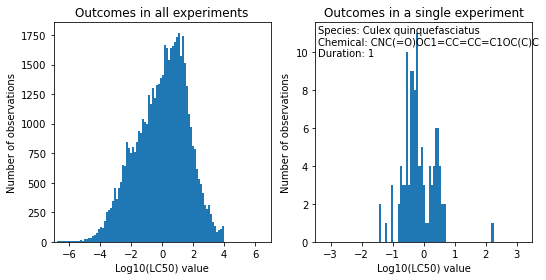

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
np.log10(df[['Value_Value']]).hist(bins=100,ax=ax1)
ax1.set_title('Outcomes in all experiments')
ax1.set_ylabel('Number of observations')
ax1.set_xlabel('Log10(LC50) value')
ax1.set_xlim(-7,7)
species, compound, duration = 'Culex quinquefasciatus', 'CNC(=O)OC1=CC=CC=C1OC(C)C', 1.0
np.log10(df.loc[(df['Species'] == species) & (df['SMILES'] == compound) & 
       (df['Duration_Value'] == duration), 'Value_Value']).hist(bins=100, ax=ax2)
ax2.set_title('Outcomes in a single experiment')
ax2.set_ylabel('Number of observations')
ax2.set_xlabel('Log10(LC50) value')
ax2.set_xlim(-3.5,3.5)
ax2.annotate('Species: %s\nChemical: %s\nDuration: %d'%(species, compound, duration), (-3.4,9.75))
ax1.grid(False)
ax2.grid(False)
fig.tight_layout()
fig.savefig('LC50_values.png')
fig.savefig('LC50_values.pdf')

In [14]:
experiments_species = df.groupby('Species')['Value_Value'].count()
experiments_drug = df.groupby('SMILES')['Value_Value'].count()

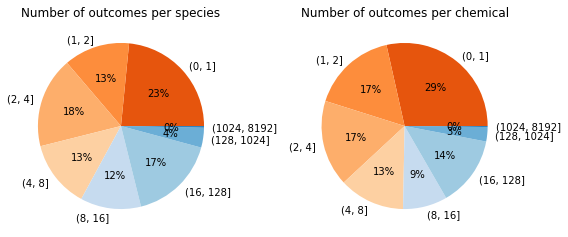

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
colors = [plt.cm.tab20c(i) for i in [4,5,6,7]] + [plt.cm.tab20c(i) for i in [3,2,1,0]]
bin_species = pd.cut(experiments_species, [0,1,2,4,8,16,128,1024,8192]).value_counts()
bin_species.name = ''
bin_species.sort_index().plot(ax=ax1, colors=colors, kind="pie", autopct='%1.0f%%',
                              title='Number of outcomes per species')
bin_drug = pd.cut(experiments_drug, [0,1,2,4,8,16,128,1024,8192]).value_counts()
bin_drug.name = ''
bin_drug.sort_index().plot(ax=ax2, colors=colors, kind="pie", autopct='%1.0f%%', 
                           title='Number of outcomes per chemical')
fig.tight_layout()
fig.savefig('sparsity_pie.png')
fig.savefig('sparsity_pie.pdf')

In [16]:
experiments_species.describe()

count    1506.000000
mean       34.709163
std       215.821011
min         1.000000
25%         2.000000
50%         4.000000
75%        13.000000
max      5005.000000
Name: Value_Value, dtype: float64

In [17]:
experiments_drug.describe()

count    2431.000000
mean       21.502262
std        93.359282
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max      1841.000000
Name: Value_Value, dtype: float64

In [18]:
take_drugs = experiments_drug.sort_values(ascending=False)[:100] #np.random.choice(experiments_drug.index, 10)
take_drugs2 = experiments_drug.sort_values(ascending=False)[-25:]
take_species = experiments_species.sort_values(ascending=False)[:100]
take_species2 = experiments_species.sort_values(ascending=False)[-25:]  #np.random.choice(experiments_species.index, 10)
df_subset = df.loc[(df['Species'].isin(take_species.index) | df['Species'].isin(take_species2.index)) &
                   (df['SMILES'].isin(take_drugs.index) | df['SMILES'].isin(take_drugs2.index)), 
                   ['Species', 'SMILES', 'Value_Value']]
df_subset = df_subset.groupby(['Species', 'SMILES'], as_index=False)['Value_Value'].agg(lambda s: np.mean(np.log10(s)))

Y = df_subset.pivot(index='Species', columns='SMILES', values='Value_Value')
Y = Y.reindex(index=list(take_species.index)+['']*25+list(take_species2.index), 
              columns=list(take_drugs.index)+['']*25+list(take_drugs2.index))

In [19]:

Yx = Y.copy().values
mask = ~np.isnan(Yx)
row, col = np.indices(Yx.shape)
rowx, colx = row[mask], col[mask] 
test = np.random.choice(np.arange(len(rowx)), int(len(rowx)/5))
train = np.delete(np.arange(len(rowx)), test)
Yx[row, col] = np.nan  
Yx[rowx[test], colx[test]] = 1.0 
Yx[rowx[train], colx[train]] = 0.0

In [20]:
import matplotlib
import matplotlib.patches as mpatches


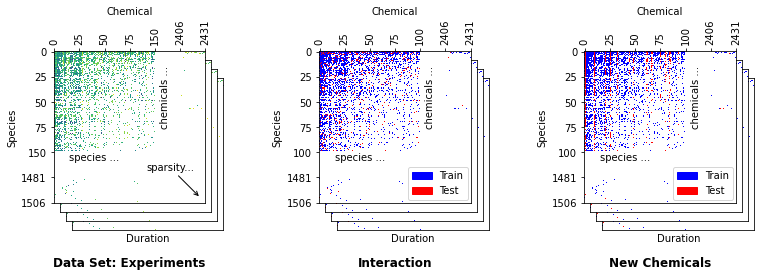

In [21]:
dpi = matplotlib.rcParams['figure.dpi'] / 1.5
width, height = Y.shape

fig = plt.figure(figsize=(width / float(dpi) *3+0.1, height / float(dpi)), layout="constrained")#
subfigs = fig.subfigures(1, 3, wspace=0.5, width_ratios=[1, 1, 1])


first = True
for offset in (0.12, 0.08, 0.04):
    ax = subfigs[0].add_axes([offset, -offset, 1.0, 1.0])
    ax.imshow(Y, interpolation='none')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if first:
        ax.set_xlabel('Duration')
        first = False
    #ax.patch.set_alpha(0.5)

ax = subfigs[0].add_axes([0, 0, 1, 1])
ax.imshow(Y, interpolation='none', cmap='viridis')
ax.annotate('species ...', (40, 105), ha='center', va='center')
ax.annotate('chemicals ...', (110, 45), ha='center', va='center', rotation=90)
ax.set_xticks([0,25,50,75,100,125,150]);
ax.set_yticks([0,25,50,75,100,125,150]);
ax.set_xticklabels([0,25,50,75,150,len(experiments_drug)-25,len(experiments_drug)], rotation = 90);
ax.set_yticklabels([0,25,50,75,150,len(experiments_species)-25,len(experiments_species)]);
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.annotate('sparsity...', xy=(145,145),  xycoords='data',
            xytext=(115, 115), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='center',
            )
ax.set_xlabel('Chemical')
ax.set_ylabel('Species')
#ax.patch.set_alpha(0.5)
#ax.axis('off')

#subfigs[0].suptitle('subfigs[0]\nLeft side')
#subfigs[0].supxlabel('xlabel for subfigs[0]')

ax.text(0.5, -0.4, 'Data Set: Experiments', transform=ax.transAxes,
  fontsize=12, fontweight='bold', va='center', ha='center')



Yx = Y.copy().values
mask = ~np.isnan(Yx)
row, col = np.indices(Yx.shape)
rowx, colx = row[mask], col[mask] 
test = np.random.choice(np.arange(len(rowx)), int(len(rowx)/5))
train = np.delete(np.arange(len(rowx)), test)
Yx[row, col] = np.nan  
Yx[rowx[test], colx[test]] = 1.0 
Yx[rowx[train], colx[train]] = 0.0

first = True
for offset in (0.12, 0.08, 0.04):
    ax = subfigs[1].add_axes([offset, -offset, 1.0, 1.0])
    ax.imshow(Yx, cmap='bwr', interpolation='none')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if first:
        ax.set_xlabel('Duration')
        first = False
    #ax.patch.set_alpha(0.5)

ax = subfigs[1].add_axes([0, 0, 1, 1])
im = ax.imshow(Yx, cmap='bwr', interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
values = (0.0, 1.0)
labels = ('Train', 'Test')
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.98, 0.02), loc=4, borderaxespad=0.)

ax.annotate('species ...', (40, 105), ha='center', va='center')
ax.annotate('chemicals ...', (110, 45), ha='center', va='center', rotation=90)
ax.set_xticks([0,25,50,75,100,125,150]);
ax.set_yticks([0,25,50,75,100,125,150]);
ax.set_xticklabels([0,25,50,75,100,len(experiments_drug)-25,len(experiments_drug)], rotation = 90);
ax.set_yticklabels([0,25,50,75,100,len(experiments_species)-25,len(experiments_species)]);
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Chemical')
ax.set_ylabel('Species')
#ax.patch.set_alpha(0.5)

ax.text(0.5, -0.4, 'Interaction', transform=ax.transAxes,
  fontsize=12, fontweight='bold', va='center', ha='center')

Yx = Y.copy()
test = np.random.choice(np.arange(Yx.shape[0]), int(Yx.shape[0]/5))
train = np.delete(np.arange(Yx.shape[0]), test)
mask = np.isnan(Yx)
Yx.iloc[:, test] = 1  
Yx.iloc[:, train] = 0 
Yx[mask] = np.nan  


first = True
for offset in (0.12, 0.08, 0.04):
    ax = subfigs[2].add_axes([offset, -offset, 1.0, 1.0])
    ax.imshow(Yx, cmap='bwr', interpolation='none')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if first:
        ax.set_xlabel('Duration')
        first = False
    #ax.patch.set_alpha(0.5)

ax = subfigs[2].add_axes([0, 0, 1, 1])
im = ax.imshow(Yx, cmap='bwr', interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
values = (0.0, 1.0)
labels = ('Train', 'Test')
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.98, 0.02), loc=4, borderaxespad=0.)

ax.annotate('species ...', (40, 105), ha='center', va='center')
ax.annotate('chemicals ...', (110, 45), ha='center', va='center', rotation=90)
ax.set_xticks([0,25,50,75,100,125,150]);
ax.set_yticks([0,25,50,75,100,125,150]);
ax.set_xticklabels([0,25,50,75,100,len(experiments_drug)-25,len(experiments_drug)], rotation = 90);
ax.set_yticklabels([0,25,50,75,100,len(experiments_species)-25,len(experiments_species)]);
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Chemical')
ax.set_ylabel('Species')
#ax.patch.set_alpha(0.5)

ax.text(0.5, -0.4, 'New Chemicals', transform=ax.transAxes,
  fontsize=12, fontweight='bold', va='center', ha='center')


fig.savefig('validation.png')
fig.savefig('validation.pdf', bbox_inches='tight')

### Illustration of explained variance

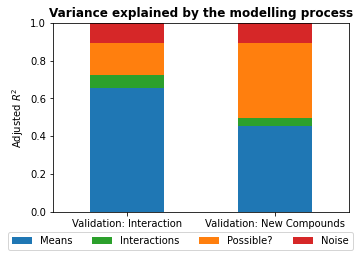

In [22]:
# results from test data
nullmodel_resvar = 1.67 ** 2
meanmodel_resvar = 0.98 ** 2
simplemodel_resvar = 0.88 ** 2
fullmodel_resvar = 0.54 **2
meanmodel_adjR2 = (nullmodel_resvar-meanmodel_resvar)/nullmodel_resvar
simplemodel_adjR2 = (nullmodel_resvar-simplemodel_resvar)/nullmodel_resvar
fullmodel_adjR2 = (nullmodel_resvar-fullmodel_resvar)/nullmodel_resvar
setting1 = pd.Series({'Means' : meanmodel_adjR2, 
                      'Interactions' : simplemodel_adjR2-meanmodel_adjR2, 
                      'Possible?': fullmodel_adjR2-simplemodel_adjR2,
                     'Noise': 1-fullmodel_adjR2})
# results from test data
nullmodel_resvar = 1.68**2
meanmodel_resvar = 1.24**2
simplemodel_resvar = 1.19**2
fullmodel_resvar = 0.54 **2
meanmodel_adjR2 = (nullmodel_resvar-meanmodel_resvar)/nullmodel_resvar
simplemodel_adjR2 = (nullmodel_resvar-simplemodel_resvar)/nullmodel_resvar
fullmodel_adjR2 = (nullmodel_resvar-fullmodel_resvar)/nullmodel_resvar
setting2 = pd.Series({'Means' : meanmodel_adjR2, 
                      'Interactions' : simplemodel_adjR2-meanmodel_adjR2, 
                      'Possible?': fullmodel_adjR2-simplemodel_adjR2,
                     'Noise': 1-fullmodel_adjR2})
st = pd.DataFrame({'Validation: Interaction':setting1, 'Validation: New Compounds': setting2}).transpose()
fig, ax = plt.subplots(1,1, figsize=(5,3.75))
st.plot(ax=ax, kind='bar', stacked=True, legend=False, color=['C0','C2', 'C1', 'C3'])
ax.set_title('Variance explained by the modelling process', fontweight='bold')
ax.set_ylabel(r'Adjusted $R^2$')
#ax.axhline(1,lw=1, linestyle='dashed', color='black')
ax.set_ylim(0,1)
plt.xticks(rotation=0)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])


fig.savefig('adjustedR2.png')
fig.savefig('adjustedR2.pdf', bbox_inches='tight')

In [23]:
setting1

Means           0.655635
Interactions    0.066693
Possible?       0.173115
Noise           0.104557
dtype: float64

In [24]:
setting2

Means           0.455215
Interactions    0.043048
Possible?       0.398420
Noise           0.103316
dtype: float64

### Prediction accuracy

In [25]:
predictions = pd.read_csv('predictions.csv')

In [26]:
n_drugs = df.groupby('SMILES')['Value_Value'].count()
n_species = df.groupby('Species')['Value_Value'].count()

In [27]:
all_models = (predictions['model'] + ' x ' + predictions['setting']).unique()

In [28]:
all_models

array(['LM0 x setting1', 'LM0 x setting2', 'LM1 x setting1',
       'LM1 x setting2', 'LM2 x setting1', 'LM3 x setting1',
       'LM4 x setting1', 'LM4 x setting2', 'LM5 x setting2',
       'LM5 x setting1', 'XL3b_final x setting1', 'XL3a_final x setting1',
       'XL5a_final x setting2', 'XL5b_final x setting2',
       'XL5a_final x setting1', 'XL5b_final x setting1', 'XGB x setting2',
       'XGB x setting1', 'TF5 x setting1', 'TF3 x setting1',
       'TF5 x setting2', 'SVR x setting1', 'SVR x setting2',
       'RF x setting1', 'RF x setting2'], dtype=object)

In [29]:
predictions.head()

,model,setting,fold,index,y_pred,y
0,LM0,setting1,3,3,-0.022153,0.708421
1,LM0,setting1,3,6,-0.022153,-1.353596
2,LM0,setting1,3,7,-0.022153,-2.481486
3,LM0,setting1,3,16,-0.022153,1.475381
4,LM0,setting1,3,17,-0.022153,0.447158


In [30]:
# Add Chemical, Species and density to predictions
df['high_density'] = df['SMILES'].isin(n_drugs[n_drugs > 16].index) & df['Species'].isin(n_species[n_species > 16].index)
predictions = df[['SMILES', 'Species', 'Duration_Value', 'high_density', 'index']].merge(predictions)

In [31]:
calc_rmse = lambda df: mean_squared_error(df['y_pred'], df['y'], squared=False)
#acc = predictions[(predictions['setting1_test1'] | predictions['setting2_test1'])]
acc = predictions.groupby(['model', 'setting']).apply(calc_rmse)
acc.name = 'rmse'
acc.reset_index().pivot(index='model', columns='setting', values='rmse').round(3)

setting,setting1,setting2
model,,
LM0,1.670,1.679
LM1,1.538,1.546
LM2,1.060,NaN
LM3,0.996,NaN
LM4,0.984,1.243
LM5,0.926,1.179
RF,1.010,1.196
SVR,0.929,1.163
TF3,0.921,NaN


In [33]:
acc = predictions.groupby(['model', 'setting', 'high_density']).apply(calc_rmse)
acc.name = 'rmse'
temp = acc.reset_index().pivot(index='model', columns=['setting', 'high_density'], values='rmse')
temp.loc[['LM0', 'LM4', 'LM5', 'RF', 'XGB', 'SVR',  'TF5','XL5b_final'],:].round(2)

setting      setting1       setting2      
high_density    False  True    False  True
model                                     
LM0              1.72  1.66     1.72  1.67
LM4              1.02  0.97     1.23  1.25
LM5              1.00  0.90     1.20  1.17
RF               1.01  1.01     1.18  1.20
XGB              1.00  0.91     1.20  1.20
SVR              0.97  0.92     1.18  1.16
TF5              0.95  0.87     1.21  1.20
XL5b_final       0.96  0.85     1.20  1.19

In [34]:
(n_drugs > 16).value_counts()

False    2026
True      405
Name: Value_Value, dtype: int64

In [35]:
len(n_drugs)

2431

In [36]:
(n_species > 16).value_counts()

False    1188
True      318
Name: Value_Value, dtype: int64

In [37]:
len(n_species)

1506

In [38]:
df['high_density'].value_counts()

True     40194
False    12078
Name: high_density, dtype: int64

In [41]:
most_measured = df.groupby('SMILES')['Species'].nunique().sort_values(ascending=False)
most_measured.head(10)

SMILES
CCOC(=O)C(CC(=O)OCC)SP(=S)(OC)OC                  278
CCOP(=S)(OC1=NC(Cl)=C(Cl)C=C1Cl)OCC               229
OC1C(Cl)=C(Cl)C(Cl)=C(Cl)C=1Cl                    226
CNC(=O)OC1C=CC=C2C=CC=CC2=1                       219
OC1C=CC=CC=1                                      194
ClC(Cl)(Cl)C(C1C=CC(Cl)=CC=1)C1C=CC(Cl)=CC=1      186
O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl     171
ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl                      168
ClC1(Cl)C2(Cl)C3C4CC(C5OC54)C3C1(Cl)C(Cl)=C2Cl    166
CC1=CC(=NC(=N1)C(C)C)OP(=S)(OCC)OCC               142
Name: Species, dtype: int64

### Illustration of RMSE

In [42]:
from scipy.stats import norm
for i in (1,2,3):
    print(norm.cdf(i) - norm.cdf(-i))


0.6826894921370859
0.9544997361036416
0.9973002039367398


In [43]:
preds = predictions[(predictions['model'] == 'XL5b_final') & (predictions['setting'] == 'setting1')].copy()
rmse = calc_rmse(preds)

C:\Users\viljanem\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


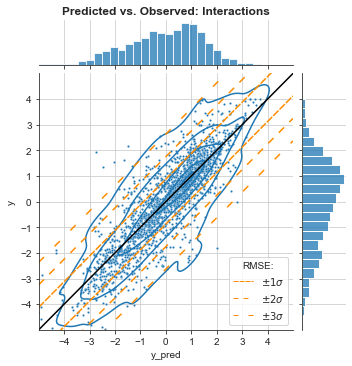

In [44]:
import matplotlib as mlp
import seaborn as sns
from matplotlib.lines import Line2D

#sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("ticks",{'axes.grid' : True})
sns.axes_style("whitegrid")

g = sns.jointplot(data=preds.sample(2000), x="y_pred", y="y", s=5, xlim=(-5,5), ylim=(-5,5), color="tab:blue", height=5)
g.plot_joint(sns.kdeplot, color="tab:blue", linewidth=0.05, levels=norm.cdf([-2,-1,0,1,2]))

# Draw a line of x=y 
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, 'black')
g.ax_joint.plot([x0, x1], [y0-rmse, y1-rmse], 'darkorange', linestyle=(0, (5, 1)))
g.ax_joint.plot([x0, x1], [y0+rmse, y1+rmse], 'darkorange', linestyle=(0, (5, 1)))
g.ax_joint.plot([x0, x1], [y0-2*rmse, y1-2*rmse], 'darkorange', linestyle=(0, (5, 5)))
g.ax_joint.plot([x0, x1], [y0+2*rmse, y1+2*rmse], 'darkorange', linestyle=(0, (5, 5)))
g.ax_joint.plot([x0, x1], [y0-3*rmse, y1-3*rmse], 'darkorange', linestyle=(0, (5, 10)))
g.ax_joint.plot([x0, x1], [y0+3*rmse, y1+3*rmse], 'darkorange', linestyle=(0, (5, 10)))
g.ax_joint.set_xticks(np.arange(-4,4+1))
g.ax_joint.set_yticks(np.arange(-4,4+1))
g.ax_marg_x.set_title('Predicted vs. Observed: Interactions', fontsize=12, fontweight='bold')
g.ax_joint.legend(handles=[Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 1)), label=r'$\pm 1\sigma$'),
                          Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 5)), label=r'$\pm 2\sigma$'),
                          Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 10)), label=r'$\pm 3\sigma$')], 
                  title='RMSE:', loc='lower right')
fig = plt.gcf()
fig.savefig('scatter1.png')
fig.savefig('scatter1.pdf', bbox_inches='tight')

In [45]:
preds["class_true"] = pd.cut(preds["y"], bins=[-np.inf, 0, 1, 2, 3, np.inf])
preds["class_pred"] = pd.cut(preds["y_pred"], bins=[-np.inf, 0, 1, 2, 3, np.inf])
conf_matrix = preds[["class_true", "class_pred"]].value_counts()
conf_matrix.name = "observations"
conf_matrix.reset_index().pivot(index="class_pred", columns="class_true")

observations                                            
class_true   (-inf, 0.0] (0.0, 1.0] (1.0, 2.0] (2.0, 3.0] (3.0, inf]
class_pred                                                          
(-inf, 0.0]        20861       2861        605        118         14
(0.0, 1.0]          2928       7471       3428        454         30
(1.0, 2.0]           337       2024       5952       1745        245
(2.0, 3.0]            72        106        627       1384        478
(3.0, inf]             2          6         17        143        364

In [46]:
preds = predictions[(predictions['model'] == 'XL5b_final') & (predictions['setting'] == 'setting2')].copy()
rmse = calc_rmse(preds)

C:\Users\viljanem\Anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


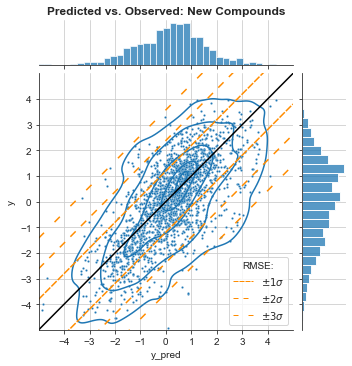

In [47]:
import matplotlib as mlp
import seaborn as sns
from matplotlib.lines import Line2D

#sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("ticks",{'axes.grid' : True})
sns.axes_style("whitegrid")

g = sns.jointplot(data=preds.sample(2000), x="y_pred", y="y", s=5, xlim=(-5,5), ylim=(-5,5), color="tab:blue", height=5)
g.plot_joint(sns.kdeplot, color="tab:blue", linewidth=0.05, levels=norm.cdf([-2,-1,0,1,2]))

# Draw a line of x=y 
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, 'black')
g.ax_joint.plot([x0, x1], [y0-rmse, y1-rmse], 'darkorange', linestyle=(0, (5, 1)))
g.ax_joint.plot([x0, x1], [y0+rmse, y1+rmse], 'darkorange', linestyle=(0, (5, 1)))
g.ax_joint.plot([x0, x1], [y0-2*rmse, y1-2*rmse], 'darkorange', linestyle=(0, (5, 5)))
g.ax_joint.plot([x0, x1], [y0+2*rmse, y1+2*rmse], 'darkorange', linestyle=(0, (5, 5)))
g.ax_joint.plot([x0, x1], [y0-3*rmse, y1-3*rmse], 'darkorange', linestyle=(0, (5, 10)))
g.ax_joint.plot([x0, x1], [y0+3*rmse, y1+3*rmse], 'darkorange', linestyle=(0, (5, 10)))
g.ax_joint.set_xticks(np.arange(-4,4+1))
g.ax_joint.set_yticks(np.arange(-4,4+1))
g.ax_marg_x.set_title('Predicted vs. Observed: New Compounds', fontsize=12, fontweight='bold')
g.ax_joint.legend(handles=[Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 1)), label=r'$\pm 1\sigma$'),
                          Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 5)), label=r'$\pm 2\sigma$'),
                          Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 10)), label=r'$\pm 3\sigma$')], 
                  title='RMSE:', loc='lower right')
fig = plt.gcf()
fig.savefig('scatter2.png')
fig.savefig('scatter2.pdf', bbox_inches='tight')

In [50]:
preds["class_true"] = pd.cut(preds["y"], bins=[-np.inf, 0, 1, 2, 3, np.inf])
preds["class_pred"] = pd.cut(preds["y_pred"], bins=[-np.inf, 0, 1, 2, 3, np.inf])
conf_matrix = preds[["class_true", "class_pred"]].value_counts()
conf_matrix.name = "observations"
conf_matrix.reset_index().pivot(index="class_pred", columns="class_true")

observations                                            
class_true   (-inf, 0.0] (0.0, 1.0] (1.0, 2.0] (2.0, 3.0] (3.0, inf]
class_pred                                                          
(-inf, 0.0]        17064       3505       1204        222         26
(0.0, 1.0]          5531       6207       4040        910        140
(1.0, 2.0]          1248       2226       4017       1557        378
(2.0, 3.0]           337        374       1016        914        413
(3.0, inf]            20        156        352        241        174